# Implementing MLPs with Keras

## Building an Image Classifier Using the Sequential API

### Using Keras to Load the Dataset

Keras provides some utility functions to fetch and load common datasets, including MNIST, Fashion MNIST, the original California housing dataset, and more. Let’s load Fashion MNIST

In [115]:
import tensorflow as tf
from tensorflow import keras

In [116]:
tf.__version__

'2.5.0'

In [117]:
keras.__version__

'2.5.0'

When loading MNIST or Fashion MNIST using Keras rather than Scikit-Learn, one important difference is that every image is represented as a array rather than a 1D array of size 784

Moreover, the pixel intensities are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0). Here is the shape and data type of the training set

In [118]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [119]:
X_train_full.shape

(60000, 28, 28)

In [120]:
X_train_full.dtype

dtype('uint8')

Note that the dataset is already split into a training set and a test set, but there is no validation set, so let’s create one

Moreover, since we are going to train the neural net work using Gradient Descent, we must scale the input features. For simplicity, we just scale the pixel intensities down to the 0-1 range by dividing them by 255.0 (this also converts them to floats)

In [121]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

With MNIST, when the label is equal to 5, it means that the image represents the handwritten digit 5. Easy. However, for Fashion MNIST, we need the list of class names to know what we are dealing with

In [122]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

For example, the first image in the training set represents a coat

In [123]:
class_names[y_train[0]]

'Coat'

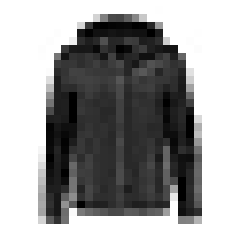

In [124]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

Let's take a look at a sample of the images in the dataset

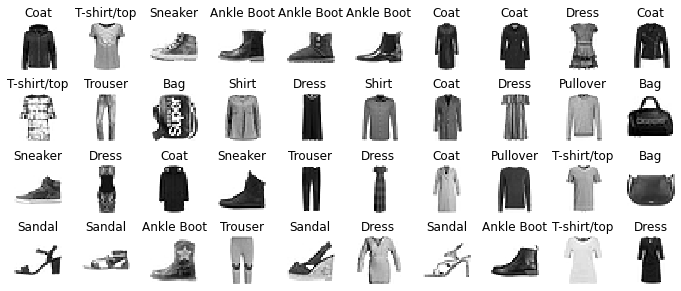

In [125]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
    plt.axis('off')
    plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Creating the Model Using the Sequential API

Now let’s build the neural network! Here is a classification MLP with two hidden layers

In [126]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

* The first line creates a Sequential model. This is the simplest kind of Keras model, for neural networks that are just composed of a single stack of layers, con nected sequentially. This is called the sequential API

* Next, we build the first layer and add it to the model. It is a Flatten layer whose role is simply to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1). This layer does not have any parameters, it is just there to do some simple preprocessing. Since it is the first layer in the model, you should specify the _shape: this does not include the batch size, only the input shape of the instances. Alternatively, you could add a keras.layers.InputLayer as the first layer, setting shape=[28,28] 

* Next we add a Dense hidden layer with 300 neurons. It will use the ReLU activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron)

* Next we add a second Dense hidden layer with 100 neurons, also using the ReLU  activation function

* Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive)

Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the Sequential model 

In [127]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')                     
])

The model’s summary() method displays all the model’s layers, including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (None means the batch size can be anything), and its number of parameters

The summary ends with the total number of parameters, including trainable and non-trainable parameters

In [128]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_49 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_50 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note that Dense layers often have a lot of parameters

For example, the first hidden layer has 784 x 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters

This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data

You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch it by name

In [129]:
model.layers

In [130]:
model.layers[1].name

'dense_48'

In [131]:
#model.get_layer('dense_3').name

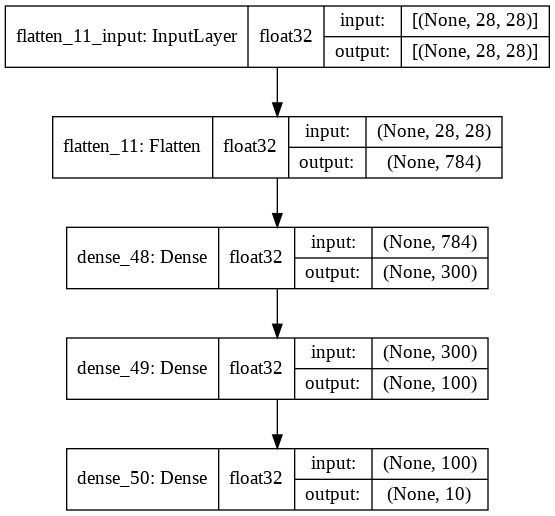

In [132]:
keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

All the parameters of a layer can be accessed using its get_weights() and set_weights() method. For a layer, this includes both the connection weights Dense and the bias terms

In [133]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
weights

array([[-0.03297673, -0.01590438,  0.00426732, ..., -0.00257946,
         0.01219875, -0.05827492],
       [-0.00409465,  0.02113777,  0.00435188, ..., -0.02016897,
        -0.0106568 , -0.03147804],
       [-0.06786427, -0.07020211, -0.04464492, ..., -0.05479212,
        -0.05457924,  0.06842355],
       ...,
       [ 0.00697115,  0.04878509,  0.0591514 , ...,  0.05613887,
         0.00419573,  0.01159373],
       [-0.01118866, -0.00266643, -0.06318136, ..., -0.01780902,
         0.03970931, -0.00255127],
       [ 0.01412144,  0.00034514, -0.02189875, ...,  0.05403614,
         0.04795641,  0.03167619]], dtype=float32)

In [134]:
weights.shape

(784, 300)

In [135]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [136]:
biases.shape

(300,)

Notice that the layer initialized the connection weights randomly (which is Dense needed to break symmetry, as we discussed earlier), and the biases were just initial ized to zeros, which is fine

If you ever want to use a different initialization method, you can set kernel_initializer (kernel is another name for the matrix of connection weights) or bias_initializer when creating the layer 

### Compiling the Model

After a model is created, you must call its compile() method to specify the loss function and the optimizer to use. Optionally, you can also specify a list of extra metrics to compute during training and evaluation

Using loss="sparse_categorical_crossentropy" is equivalent to  loss=keras.losses.sparse_categorical_crossentropy. Similarly optimizer="sgd" is equivalent to optimizer=keras.optimizers.SGD() and metrics=["accuracy"] is equivalent to metrics=[keras.metrics.sparse_categorical_accuracy] (when  using this loss)

In [137]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy']
              )

First, we use the "sparse_categorical_crossentropy" loss because we have sparse labels (i.e., for each instance there is just a target class index, from 0 to 9 in this case), and the classes are exclusive

If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need  to use the "categorical_crossentropy" loss instead

If we were doing binary classification (with one or more binary labels), then we would use the "sigmoid" (i.e., logistic) activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss 

Secondly, regarding the optimizer, simply means that we will train the model "sgd" using simple Stochastic Gradient Descent. In other words, Keras will perform the backpropagation algorithm described earlier (i.e., reverse-mode autodiff + Gradient Descent)

Finally, since this is a classifier, it’s useful to measure its "accuracy" during training  and evaluation

If you want to convert sparse labels (i.e., class indices) to one-hot vector labels, you can use the keras.utils.to_categorical() function. To go the other way round, you can just use the np.argmax() function with axis=1

### Training and Evaluating the Model

Now the model is ready to be trained. For this we simply need to call its fit() method. We pass it the input features (X_train) and the target classes (y_train), as well as the number of epochs to train (or else it would default to just 1, which would definitely not be enough to converge to a good solution)

We also pass a validation set (this is optional): Keras will measure the loss and the extra metrics on this set at the end of each epoch, which is very useful to see how well the model really performs: if the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a data mis match between the training set and the validation set)


In [138]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7135 - accuracy: 0.7645 - val_loss: 0.5224 - val_accuracy: 0.8192
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4867 - accuracy: 0.8301 - val_loss: 0.4384 - val_accuracy: 0.8522
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4412 - accuracy: 0.8453 - val_loss: 0.4309 - val_accuracy: 0.8520
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4133 - accuracy: 0.8563 - val_loss: 0.4118 - val_accuracy: 0.8606
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3936 - accuracy: 0.8630 - val_loss: 0.3987 - val_accuracy: 0.8588
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3779 - accuracy: 0.8665 - val_loss: 0.3652 - val_accuracy: 0.8770
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3641 - accuracy: 0.8716 - val_loss: 0.3686 - val_accuracy:

And that’s it! The neural network is trained. At each epoch during training, Keras displays the number of instances processed so far (along with a progress bar), the mean training time per sample, the loss and accuracy (or any other extra metrics you asked for), both on the training set and the validation set

You can see that the training loss went down, which is a good sign, and the validation accuracy reached 89% after 50 epochs, not too far from the training accuracy, so there does not seem to be much overfitting going on

Instead of passing a validation set using the validation_data argument, you could instead set to the ratio of validation_split the training set that you want Keras to use for validation

If the training set was very skewed, with some classes being overrepresented and others underrepresented, it would be useful to set the class_weight argument when calling the fit() method, giving a larger weight to underrepresented classes, and a lower weight to overrepresented classes. These weights would be used by Keras when computing the loss

If you need per-instance weights instead, you can set the sample_weight argument (it supersedes class_weight). This could be useful for example if some instances were labeled by experts while others were labeled using a crowdsourcing platform: you might want to give more weight to the former. You can also provide sample weights (but not class weights) for the validation set by adding them as a third item in the validation_data tuple 

The fit() method returns a History object containing the training parameters (history.params), 


the list of epochs it went through (history.epoch), and most importantly a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any)

If you create a Pandas DataFrame using this dictionary and call its plot() method, you get the learning curves

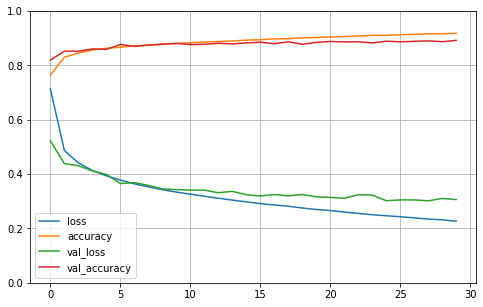

In [139]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

You can see that both the training and validation accuracy steadily increase during training, while the training and validation loss decrease. Moreover, the valida tion curves are quite close to the training curves, which means that there is not too much overfitting

You can tell that the model has not quite converged yet, as the validation loss is still going down, so you should probably continue train ing. It’s as simple as calling the fit() method again, since Keras just continues training where it left off

If you are not satisfied with the performance of your model, you should go back and tune the model’s hyperparameters, for example the number of layers, the number of neurons per layer, the types of activation functions we use for each hidden layer, the number of training epochs, the batch size (it can be set in the fit() method using the batch_size argument, which defaults to 32) 


Once you are satisfied with your model’s validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production

You can easily do this using the evaluate() method 

In [140]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 75.8443 - accuracy: 0.8306


[75.84430694580078, 0.8306000232696533]

It is common to get slightly lower performance on the test set than on the validation set, because the hyperparameters are tuned on the validation set, not the test set (however, in this example, we did not do any hyperparameter tun ing, so the lower accuracy is just bad luck). Remember to resist the temptation to tweak the hyperparameters on the test set, or else your estimate of the generalization error will be too optimistic

### Using the Model to Make Predictions

Next, we can use the model’s predict() method to make predictions on new instances. Since we don’t have actual new instances, we will just use the first 3 instances of the test set

In [141]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

As you can see, for each instance the model estimates one probability per class, from class 0 to class 9

If you only care about the class with the highest estima ted probability (even if that probability is quite low) then you can use the pre method instead dict_classes()

In [142]:
y_pred = model.predict_classes(X_new)
y_pred

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([9, 2, 1])

In [143]:
import numpy as np
np.array(class_names)[y_pred]

array(['Ankle Boot', 'Pullover', 'Trouser'], dtype='<U11')

## Building a Regression MLP Using the Sequential API

Let’s switch to the California housing problem and tackle it using a regression neural network

For simplicity, we will use Scikit-Learn’s fetch_california_housing() function to load the data: this dataset is simpler than the one we used in Chapter 2, since it contains only numerical features (there is no ocean_proximity  feature), and there is no missing value

After loading the data, we split it into a training set, a vali dation set and a test set, and we scale all the features

In [144]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)
X_test_scaled = scaler.transform(X_test)

Building, training, evaluating and using a regression MLP using the Sequential API to make predictions is quite similar to what we did for classification. The main differ ences are the fact that the output layer has a single neuron (since we only want to predict a single value) and uses no activation function, and the loss function is the mean squared error

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting

In [145]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='sgd')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: nan - val_loss: nan
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 3/20
363/363 [==============================] - 0s 961us/step - loss: nan - val_loss: nan
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 5/20
363/363 [==============================] - 0s 967us/step - loss: nan - val_loss: nan
Epoch 6/20
363/363 [==============================] - 0s 974us/step - loss: nan - val_loss: nan
Epoch 7/20
363/363 [==============================] - 0s 963us/step - loss: nan - val_loss: nan
Epoch 8/20
363/363 [==============================] - 0s 941us/step - loss: nan - val_loss: nan
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/20
363/363 [==============================] - 0s 939us/step - loss: nan - val_loss: nan
Epoch 11/20
363/363 [==========================

As you can see, the Sequential API is quite easy to use. However, although sequential models are extremely common, it is sometimes useful to build neural networks with more complex topologies, or with multiple inputs or outputs. For this purpose, Keras offers the Functional API

## Building Complex Models Using the Functional API

One example of a non-sequential neural network is a Wide & Deep neural network, It connects all or part of the inputs directly to the output layer

This architecture makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path)

In contrast, a regular MLP forces all the data to flow through the full stack of layers, thus simple patterns in the data may end up being distorted by this sequence of transformations

<p align="center">
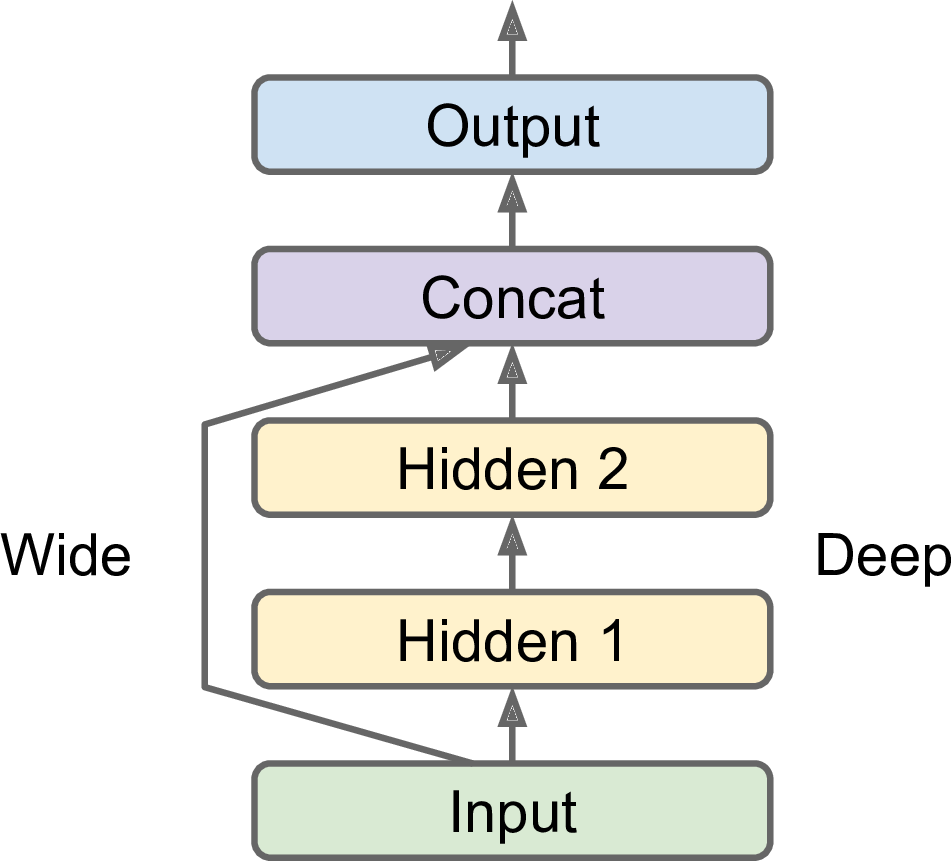
</p>

Let’s build such a neural network to tackle the California housing problem

In [146]:
input = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input], outputs=[output])

Let’s go through each line of this code:
*   First, we need to create an object. This is needed because we may have Input multiple inputs, as we will see later
*   Next, we create a layer with 30 neurons and using the ReLU activation Dense function. As soon as it is created, notice that we call it like a function, passing it the input. This is why this is called the Functional API. Note that we are just telling Keras how it should connect the layers together, no actual data is being processed yet
*   We then create a second hidden layer, and again we use it as a function. Note however that we pass it the output of the first hidden layer
*   Next, we create a Concatenate() layer, and once again we immediately use it like a function, to concatenate the input and the output of the second hidden layer (you may prefer the keras.layers.concatenate() function, which creates a Concatenate layer and immediately calls it with the given inputs) 
*   Then we create the output layer, with a single neuron and no activation function, and we call it like a function, passing it the result of the concatenation
*   Lastly, we create a Keras Model, specifying which inputs and outputs to use




Once you have built the Keras model, everything is exactly like earlier, so no need to repeat it here: you must compile the model, train it, evaluate it and use it to make predictions

But what if you want to send a subset of the features through the wide path, and a
different subset (possibly overlapping) through the deep path



<p align="center">
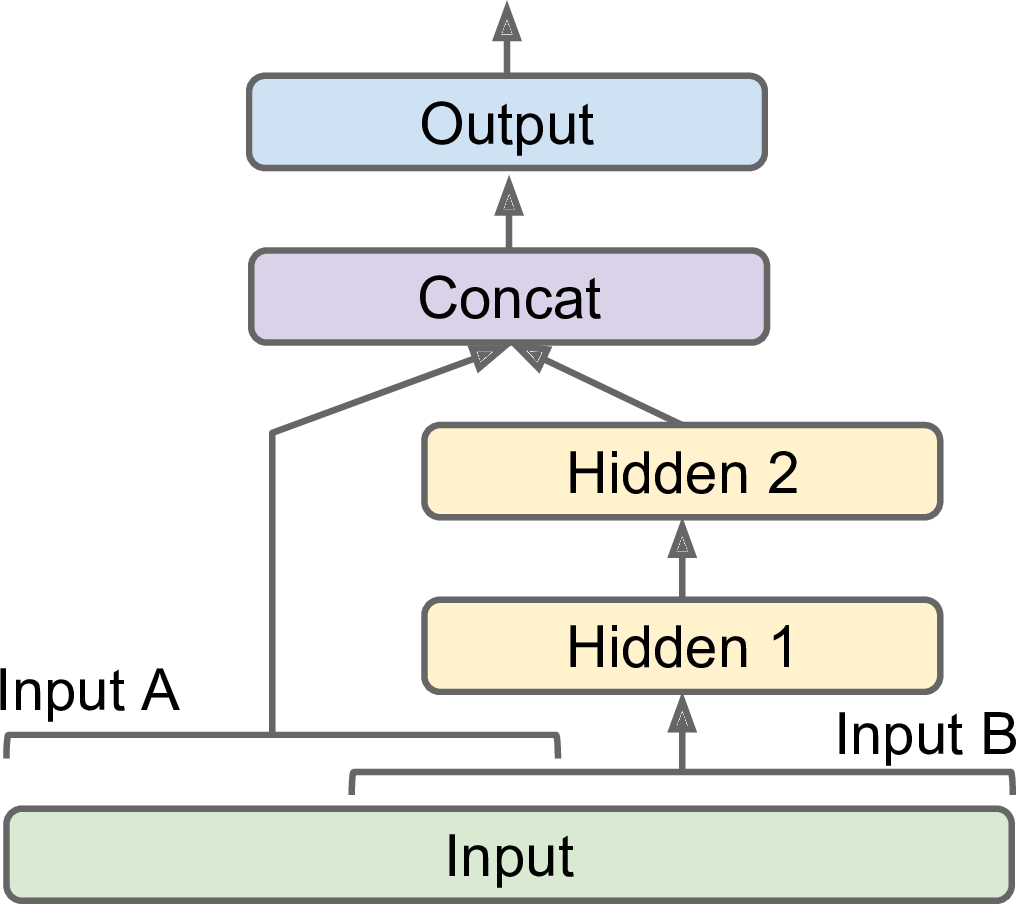
</p>

In this case, one solution is to use multiple inputs. For example, suppose we want to send 5 features through the deep path (features 0 to 4), and 6 features through the wide path (features 2 to 7)

In [147]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

The code is self-explanatory. Note that we specified inputs=[input_A, input_B] when creating the model

Now we can compile the model as usual, but when we call the fit() method, instead of passing a single input matrix X_train, we must pass a pair of matrices (X_train_A, X_train_B): one per input 

The same is true for X_valid, and also for X_test and X_new when you call evaluate() or predict()   

In [148]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


363/363 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: nan - val_loss: nan
Epoch 11/20
363/363 [==============================] - 0s 1ms/step - l

There are also many use cases in which you may want to have multiple outputs

* The task may demand it, for example you may want to locate and classify the main object in a picture. This is both a regression task (finding the coordinates of the object’s center, as well as its width and height) and a classification task
* Similarly, you may have multiple independent tasks to perform based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks
* Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model’s ability to general ize). For example, you may want to add some auxiliary outputs in a neural net work architecture (see Figure Below) to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network

<p align="center">
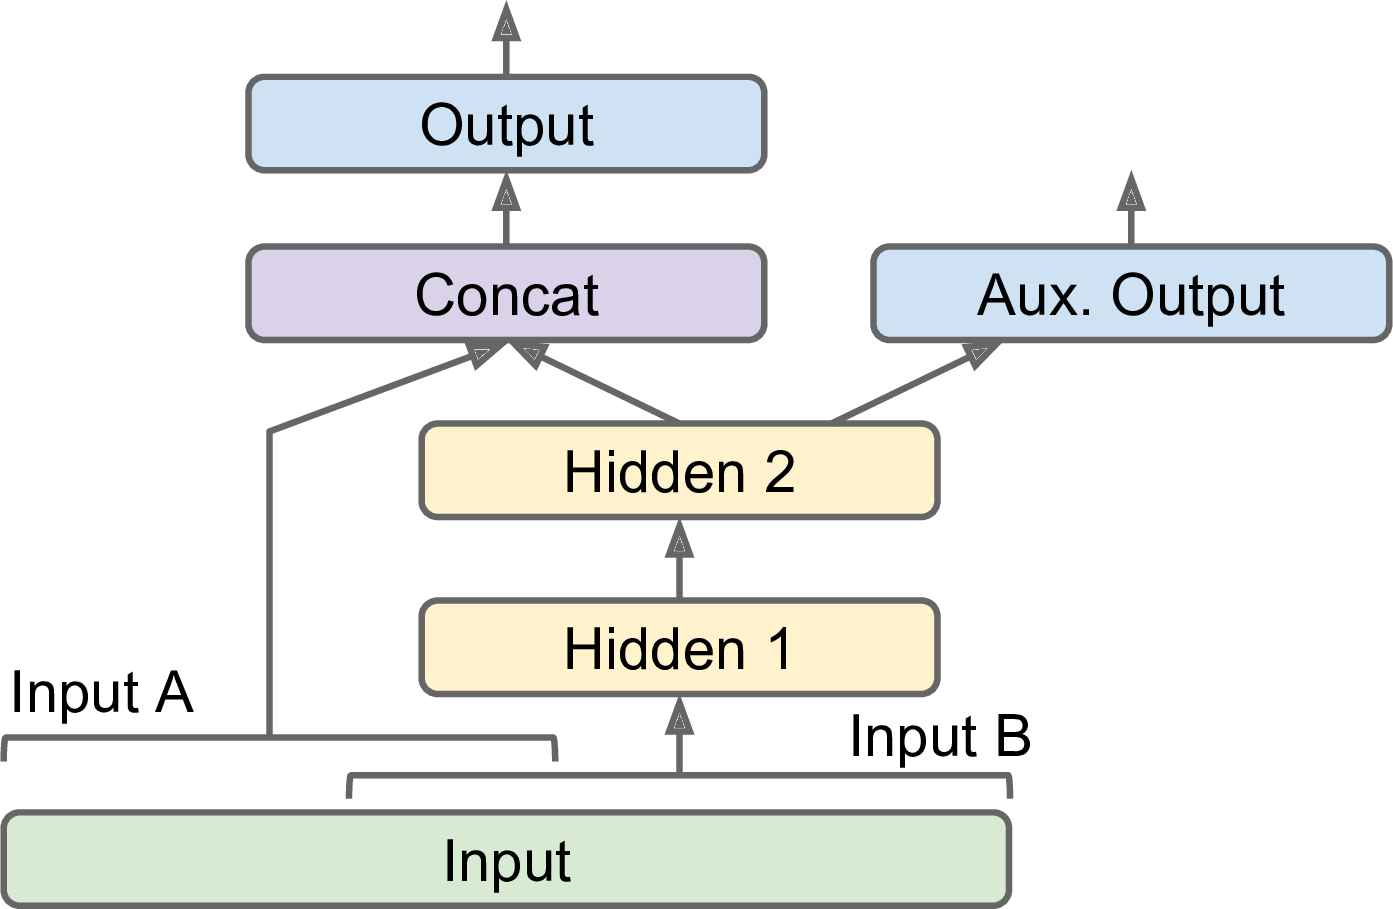
</p>

Adding extra outputs is quite easy: just connect them to the appropriate layers and add them to your model’s list of outputs. For example, the following code builds the network represented in Figure above

In [149]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

Each output will need its own loss function, so when we compile the model we should pass a list of losses (if we pass a single loss, Keras will assume that the same loss must be used for all outputs)

By default, Keras will compute all these losses and simply add them up to get the final loss used for training. However, we care much more about the main output than about the auxiliary output (as it is just used for reg ularization), so we want to give the main output’s loss a much greater weight. Fortu nately, it is possible to set all the loss weights when compiling the model

In [150]:
model.compile(loss=['mse', 'mse'], loss_weights=[0.9, 0.1], optimizer='sgd')

Now when we train the model, we need to provide some labels for each output. In this example, the main output and the auxiliary output should try to predict the same thing, so they should use the same labels

So instead of passing y_train, we just need to pass ( y_train, y_train) (and the same goes for y_valid and y_test)  

In [151]:
history = model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: nan - dense_60_loss: nan - dense_61_loss: nan - val_loss: nan - val_dense_60_loss: nan - val_dense_61_loss: nan
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: nan - dense_60_loss: nan - dense_61_loss: nan - val_loss: nan - val_dense_60_loss: nan - val_dense_61_loss: nan
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: nan - dense_60_loss: nan - dense_61_loss: nan - val_loss: nan - val_dense_60_loss: nan - val_dense_61_loss: nan
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: nan - dense_60_loss: nan - dense_61_loss: nan - val_loss: nan - val_dense_60_loss: nan - val_dense_61_loss: nan
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: nan - dense_60_loss: nan - dense_61_loss: nan - val_loss: nan - val_dense_60_loss: nan - val_dense_61_loss: nan
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - lo

When we evaluate the model, Keras will return the total loss, as well as all the individual losses

In [152]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 853us/step - loss: nan - dense_60_loss: nan - dense_61_loss: nan


Similarly, the predict() method will return predictions for each output 

In [153]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

As you can see, you can build any sort of architecture you want quite easily with the Functional API. Let’s look at one last way you can build Keras models

## Building Dynamic Models Using the Subclassing API

Both the Sequential API and the Functional API are declarative: you start by declaring which layers you want to use and how they should be connected, and only then can you start feeding the model some data for training or inference

This has many advantages: the model can easily be saved, cloned, shared, its structure can be displayed and analyzed, the framework can infer shapes and check types, so errors can be caught early (i.e., before any data ever goes through the model). It’s also fairly easy to debug, since the whole model is just a static graph of layers

But the flip side is just that: it’s static. Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more imperative programming style, the Subclassing API is for you



Simply subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method 

For example, cre ating an instance of the following WideAndDeepModel class gives us an equivalent model to the one we just built with the Functional API.

In [154]:
class WideAndDeepModel(keras.models.Model):
  def __init__(self, units=30, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.hidden1 = keras.layers.Dense(units, activation=activation)
    self.hidden2 = keras.layers.Dense(units, activation=activation)
    self.main_output = keras.layers.Dense(1)
    self.aux_output = keras.layers.Dense(1)

  def call(self, inputs):
    input_A, input_B = inputs
    hidden1 = self.hidden1(input_B)
    hidden2 = self.hidden2(hidden1)
    concat = keras.layers.concatenate([input_A, hidden2])
    main_output = self.main_output(concat)
    aux_output = self.aux_output(hidden2)
    return main_output, aux_output
  
model_ = WideAndDeepModel()

This example looks very much like the Functional API, except we do not need to create the inputs, we just use the input argument to the call() method, and we separate the creation of the layers in the constructor from their usage in the call() method 

However, the big difference is that you can do pretty much anything you want in the call() method: for loops, if statements, low-level TensorFlow operations   

However, this extra flexibility comes at a cost: your model’s architecture is hidden within the call() method, so Keras cannot easily inspect it, it cannot save or clone it, and when you call the summary() method, you only get a list of layers, without any  information on how they are connected to each other

Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. So unless you really need that extra flexibility, you should probably stick to the Sequential API or the Functional API

## Saving and Restoring a Model

Saving a trained Keras model is as simple as it gets

This will work when using the Sequential API or the Functional API, but unfortunately not when using Model subclassing. How ever, you can use save_weights() and load_weights() to at least save and restore the model parameters (but you will need to save and restore everything else yourself)

In [155]:
model.save('my_keras_model.h5')

Keras will save both the model’s architecture (including every layer’s hyperparame ters) and the value of all the model parameters for every layer (e.g., connection weights and biases), using the HDF5 format. It also saves the optimizer (including its hyperparameters and any state it may have)

You will typically have a script that trains a model and saves it, and one or more scripts (or web services) that load the model and use it to make predictions. Loading the model is just as easy

In [156]:
model = keras.models.load_model('my_keras_model.h5')

But what if training lasts several hours? This is quite common, especially when train ing on large datasets. In this case, you should not only save your model at the end of training, but also save checkpoints at regular intervals during training. But how can you tell the fit() method to save checkpoints? The answer is: using callbacks 

## Using Callbacks

The fit() method accepts a callbacks argument that lets you specify a list of objects that Keras will call during training at the start and end of training, at the start and end of each epoch and even before and after processing each batch

For example, the ModelCheckpoint callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch



```
# [...] build and compile the model
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5')
history = model.fit(X_train, y_train, epochs=10, callbacks=[checkpoint_cb])
```



Moreover, if you use a validation set during training, you can set save_best_only=True when creating the ModelCheckpoint 

In this case, it will only save your model when its performance on the validation set is the best so far. This way, you do not need to worry about training for too long and overfitting the training set: simply restore the last model saved after training, and this will be the best model on the validation set. This is a simple way to implement early stopping



```
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5',
                                                save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model('my_keras_model.h5')
```



Another way to implement early stopping is to simply use the EarlyStopping callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and it will optionally roll back to the best model

You can combine both callbacks to both save checkpoints of your model (in case your computer crashes), and actually interrupt training early when there is no more progress (to avoid wasting time and resources)




```
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
```



The number of epochs can be set to a large value since training will stop automati cally when there is no more progress. Moreover, there is no need to restore the best model saved in this case since the EarlyStopping callback will keep track of the best weights and restore them for us at the end of training

If you need extra control, you can easily write your own custom callbacks. For example, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting)

In [160]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

As you might expect, you can implement on_train_begin(), on_train_end(), on_epoch_begin() and on_batch_end()

Moreover, callbacks can also be used during evaluation and predictions, should you ever need them (e.g., for debugging). In this case, you should implement on_test_begin(), on_test_end(), on_test_batch_begin(), on_batch_end() or on_predict_begin()

Now let’s take a look at one more tool you should definitely have in your toolbox when using tf.keras: TensorBoard


## Visualization Using TensorBoard